The followings are refereced from [here](https://people.duke.edu/~ccc14/sta-663/MCMC.html). 

This notebook includes the basic tutorials on Markov Chain Monte Carlo method and useful samplings. 

In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
%precision 4 
plt.style.use('ggplot')

In [53]:
3/5 # because of %precision 4

0.6000

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from functools import partial

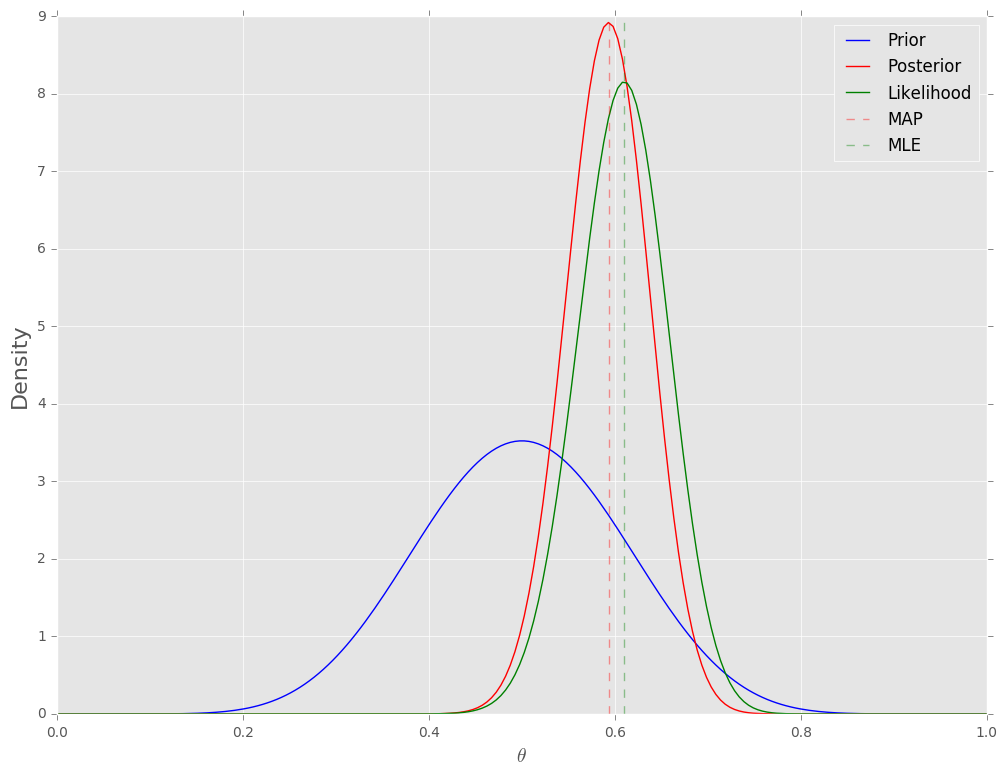

In [19]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

thetas = np.linspace(0, 1, 200)



a, b = 10, 10
prior = st.beta(a, b)
#post = st.beta(h+a, n-h+b)
post = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)
post /= (post.sum() / len(thetas))
#ci = post.interval(0.95)

plt.figure(figsize=(12, 9))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
#plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, post, label='Posterior', c='red')

plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
#plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

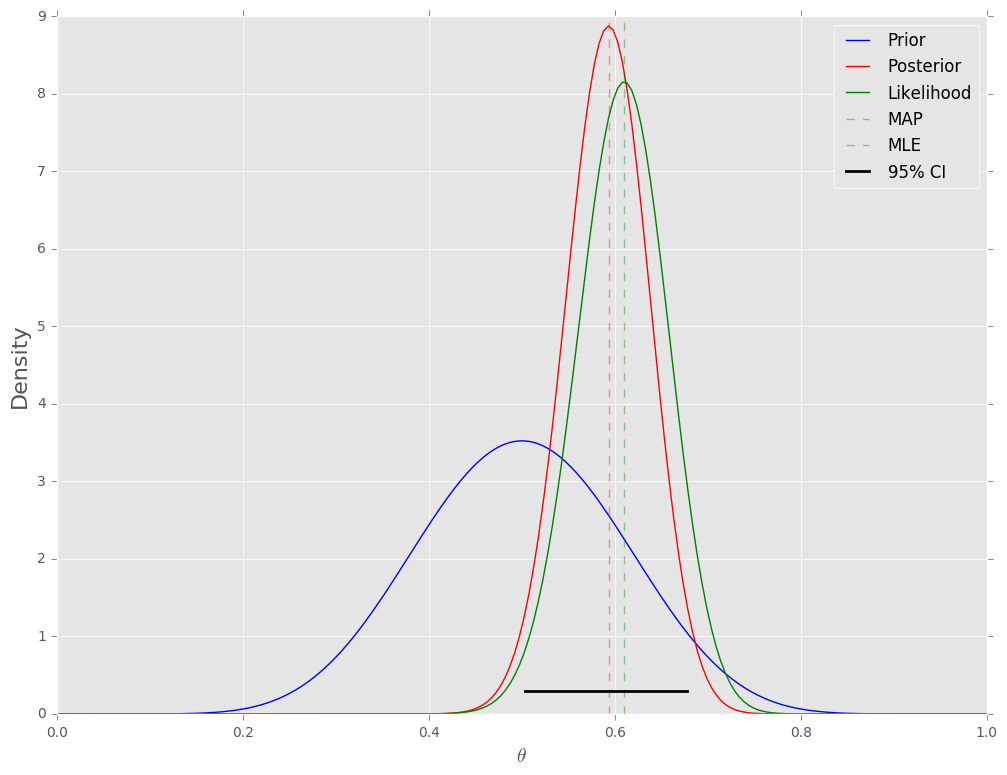

In [21]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

a, b = 10, 10
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')

plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

# Metropolis-Hastings MC

In [116]:
st.binom(10, 0.5).pmf(10), 1/2**10

(0.0010, 0.0010)

In [127]:
 np.linspace(0, 1, 5) 

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ])

In [121]:
%%time
def target(lik, prior, n, h, theta): # probability with pmf
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)
"""lik will become binom(n, theta) later. 
lik(n, theta).pmf(h) means the prob when h of n happens with the theta, prob of the event
"""
    
    
n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3
thetas = np.linspace(0, 1, 200) # size of the steps is 1/199



naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1) # newly chosen data will be momorized here 
samples[0] = theta

for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs() 
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho: # this 'if' enables to accept the new state with probability rho
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2  # some samples are deserted before Markov chains converges
print "Efficiency = ", naccept/niters

Efficiency =  0.1809
CPU times: user 31.8 s, sys: 187 ms, total: 32 s
Wall time: 32 s


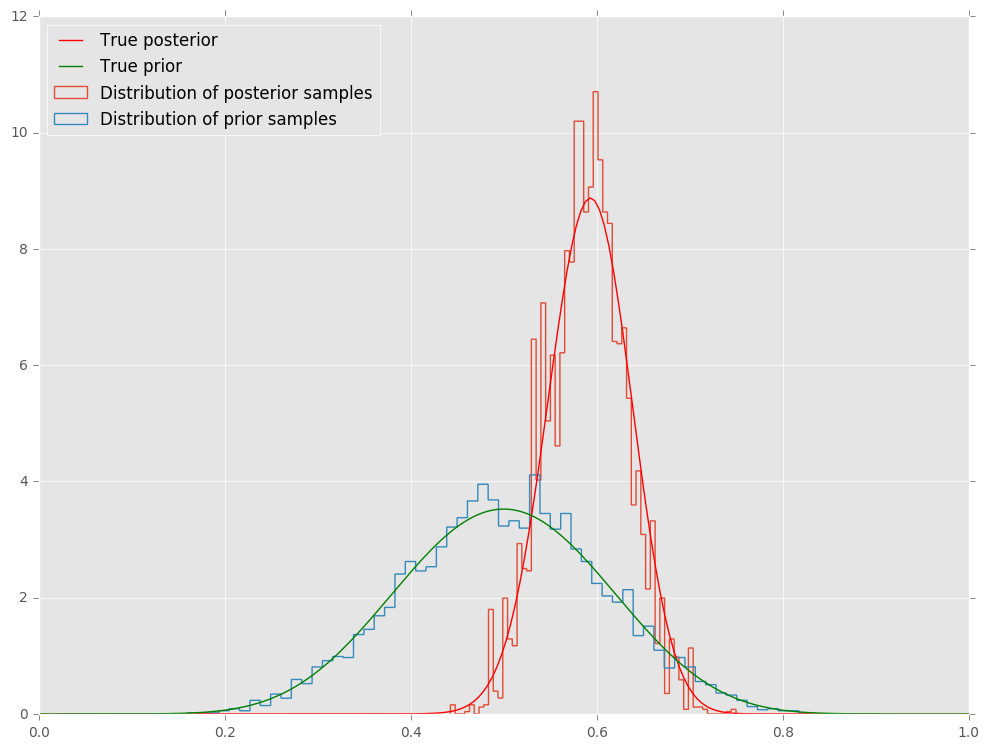

In [122]:
post = st.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], naccept//30, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.hist(prior.rvs(nmcmc), naccept//30, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='-', label='True posterior')
plt.plot(thetas, prior.pdf(thetas), label='True prior', c='green')
plt.xlim([0,1]);
plt.legend(loc='best');

# Markov chain converges

In [29]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [30]:
%%time

n = 100
h = 61
lik = st.binom
a=10
b=10
prior = st.beta(a, b)
sigma = 0.05
niters = 200

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

CPU times: user 3.33 s, sys: 26.7 ms, total: 3.35 s
Wall time: 3.35 s


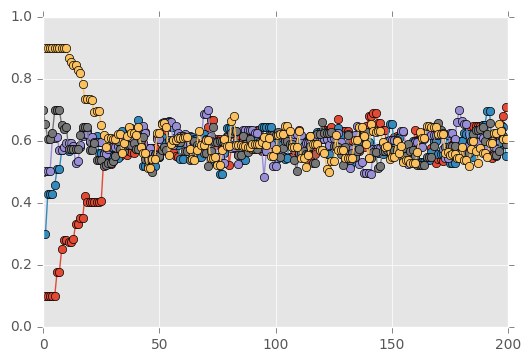

In [31]:
# Convergence of multiple chains with 100 iterations

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

In [45]:
p=0.3
(1-p)*p/(1-p), p+(1-p/(1-p))*(1-p)

(0.3000, 0.7000)

Simpler approach

In [46]:
T = [[0,1,0],[0,0.1,.9],[0.6,.4,0]] # transform operation

In [47]:
np.linalg.det(T)

0.5400

In [48]:
T=np.array(T)
T

array([[ 0. ,  1. ,  0. ],
       [ 0. ,  0.1,  0.9],
       [ 0.6,  0.4,  0. ]])

In [49]:
m=np.array([np.random.rand(),np.random.rand(),np.random.rand()]) # arbitrary initial state
T**1000

array([[  0.0000e+000,   1.0000e+000,   0.0000e+000],
       [  0.0000e+000,   0.0000e+000,   1.7479e-046],
       [  1.4166e-222,   0.0000e+000,   0.0000e+000]])

In [50]:
np.dot(m,T**100), np.dot(m,T**1000), np.dot(m,T**10000) # it converges 

(array([  4.8495e-24,   4.8302e-01,   1.5853e-05]),
 array([  1.0515e-223,   4.8302e-001,   1.0432e-046]),
 array([ 0.   ,  0.483,  0.   ]))

# Gibbs sampler

In [3]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes."""
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)

In [13]:
a=make_thetas(0,1,4)

In [15]:
a

array([ 0.1667,  0.5   ,  0.8333])

In [14]:
bern(a, 2,10)

array([  6.4602e-03,   9.7656e-04,   4.1345e-07])

In [4]:
def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [5]:
def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2
    thetas = xs[:-1]+ widths
    return thetas

In [6]:
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(10,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior)
        ax[1].contour(X, Y, likelihood)
        ax[2].contour(X, Y, posterior)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()


In [7]:
thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)

X, Y = np.meshgrid(thetas1, thetas2)
print "thetas1:" 
print thetas1
print "thetas2:" 
print thetas2
np.meshgrid(range(10), range(10,15))

thetas1:
[ 0.005  0.015  0.025  0.035  0.045  0.055  0.065  0.075  0.085  0.095
  0.105  0.115  0.125  0.135  0.145  0.155  0.165  0.175  0.185  0.195
  0.205  0.215  0.225  0.235  0.245  0.255  0.265  0.275  0.285  0.295
  0.305  0.315  0.325  0.335  0.345  0.355  0.365  0.375  0.385  0.395
  0.405  0.415  0.425  0.435  0.445  0.455  0.465  0.475  0.485  0.495
  0.505  0.515  0.525  0.535  0.545  0.555  0.565  0.575  0.585  0.595
  0.605  0.615  0.625  0.635  0.645  0.655  0.665  0.675  0.685  0.695
  0.705  0.715  0.725  0.735  0.745  0.755  0.765  0.775  0.785  0.795
  0.805  0.815  0.825  0.835  0.845  0.855  0.865  0.875  0.885  0.895
  0.905  0.915  0.925  0.935  0.945  0.955  0.965  0.975  0.985  0.995]
thetas2:
[ 0.005  0.015  0.025  0.035  0.045  0.055  0.065  0.075  0.085  0.095
  0.105  0.115  0.125  0.135  0.145  0.155  0.165  0.175  0.185  0.195
  0.205  0.215  0.225  0.235  0.245  0.255  0.265  0.275  0.285  0.295
  0.305  0.315  0.325  0.335  0.345  0.355  0.365  0.375  

[array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
 array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14]])]

CPU times: user 401 ms, sys: 18.1 ms, total: 419 ms
Wall time: 442 ms


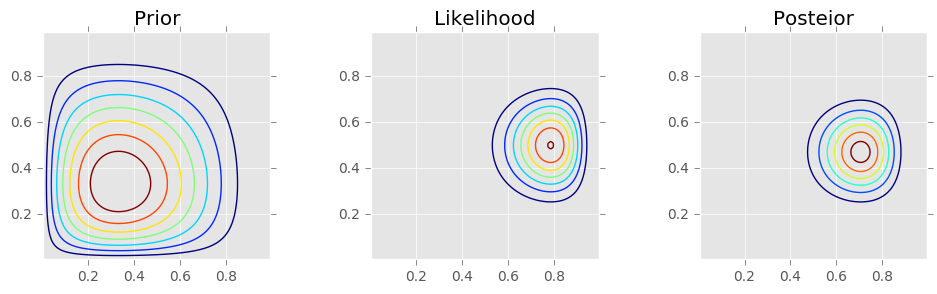

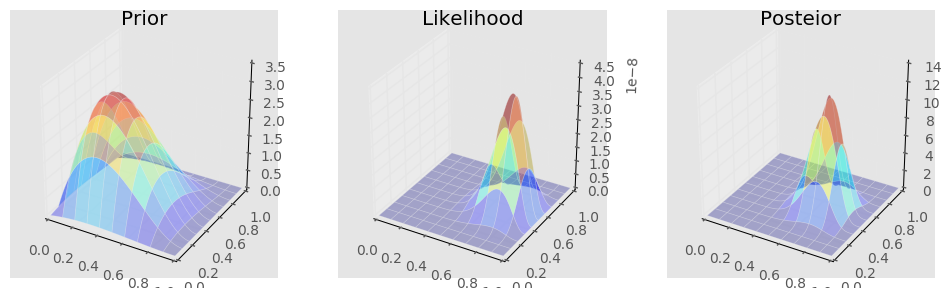

In [8]:
%%time 

a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = st.beta(a, b).pdf(X) * st.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = st.beta(a + z1, b + N1 - z1).pdf(X) * st.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

In [61]:
def c2d(thetas1, thetas2, pdf):
    width1 = thetas1[1] - thetas1[0]
    width2 = thetas2[1] - thetas2[0]
    area = width1 * width2
    pmf = pdf * area
    pmf /= pmf.sum()
    return pmf

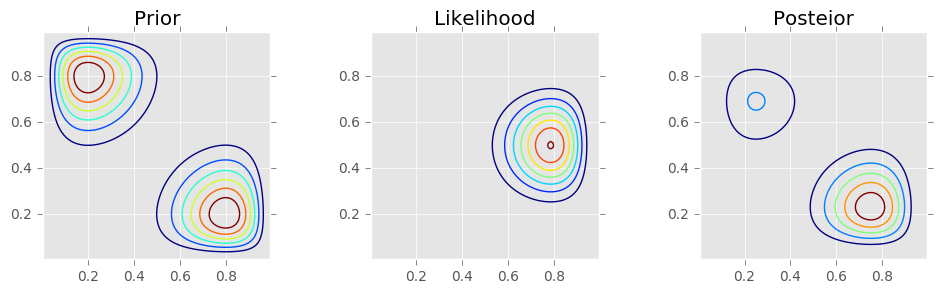

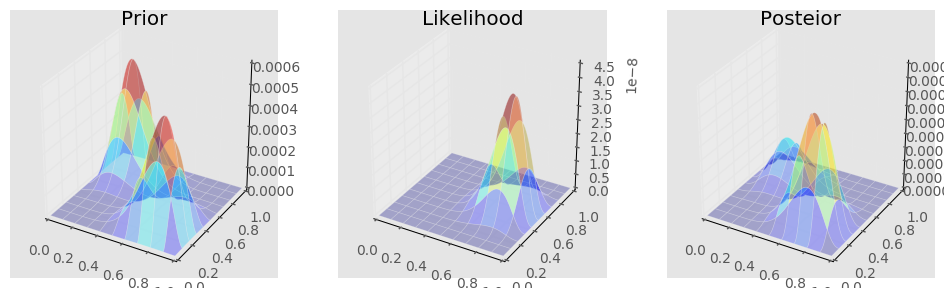

In [62]:
_prior = bern2(X, Y, 2, 8, 10, 10) + bern2(X, Y, 8, 2, 10, 10)
prior_grid = c2d(thetas1, thetas2, _prior)
_likelihood = bern2(X, Y, 1, 1, 2, 3)
posterior_grid = _likelihood * prior_grid
posterior_grid /= posterior_grid.sum()
make_plots(X, Y, prior_grid, likelihood, posterior_grid)
make_plots(X, Y, prior_grid, likelihood, posterior_grid, projection='3d')

In [63]:
from functools import partial

In [64]:
## understanding to functiontool, partial 

def power(base, coeff, exponent):
    return coeff* base ** exponent
square = partial(power, exponent=2)
cube = partial(power, exponent=3)

square(2,2), cube(3,1), cube(3,1, exponent=4)

(8, 27, 81)

In [80]:
%%time

a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

# prior, lik, target
prior = lambda theta1, theta2: st.beta(a, b).pdf(theta1) * st.beta(a, b).pdf(theta2)


lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)
"""
def bern2(theta1, theta2, z1, z2, N1, N2):
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)
"""


theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin, 2), np.float)

# Metropolis sampling
for i in range(niters): 
    new_theta = st.multivariate_normal(theta, sigma).rvs()
    p = min(target(*new_theta)/target(*theta), 1)
    if np.random.rand() < p:
        theta = new_theta
    if i >= burnin:
        thetas[i-burnin] = theta


CPU times: user 49.3 s, sys: 355 ms, total: 49.6 s
Wall time: 49.7 s


In [82]:
thetas.shape # no reject

(9500, 2)

In [83]:
thetas

array([[ 0.7498,  0.3259],
       [ 0.7498,  0.3259],
       [ 0.7498,  0.3259],
       ..., 
       [ 0.726 ,  0.4755],
       [ 0.726 ,  0.4755],
       [ 0.726 ,  0.4755]])

In [84]:
thetas.T[0]

array([ 0.7498,  0.7498,  0.7498, ...,  0.726 ,  0.726 ,  0.726 ])

In [86]:
np.sqrt(9500)

97.4679

CPU times: user 2.84 s, sys: 20.4 ms, total: 2.86 s
Wall time: 2.86 s


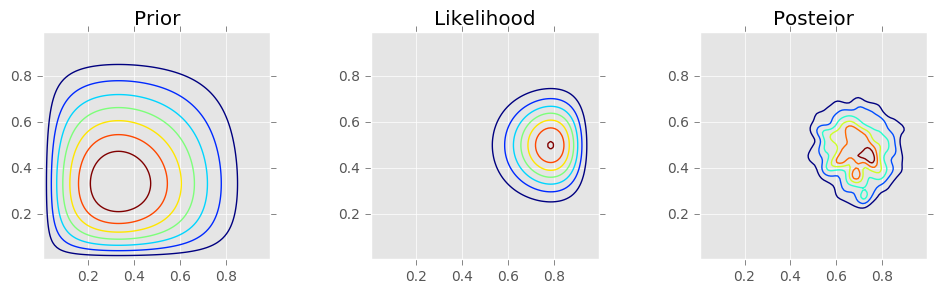

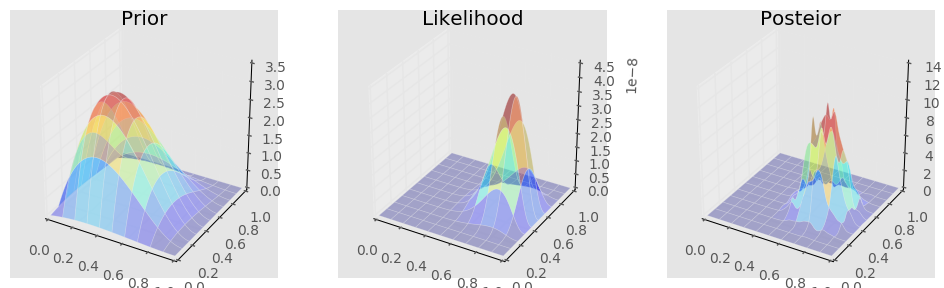

In [87]:
%%time
"""
KDE, Kernel density estimation : 
A common task in statistics is to estimate the probability density function 
(PDF) of a random variable from a set of data samples. 
This task is called density estimation. The most well-known tool to do this
is the histogram. A histogram is a useful tool for visualization 
(mainly because everyone understands it), but doesn’t use the available data 
very efficiently. Kernel density estimation (KDE) is a more efficient tool 
for the same task. The gaussian_kde estimator can be used to estimate 
the PDF of univariate as well as multivariate data. 
It works best if the data is unimodal."""

kde = st.gaussian_kde(thetas.T) # From MH samples, estimate the density. 
XY = np.vstack([X.ravel(), Y.ravel()]) # make the data 1d-array
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis, projection='3d')

In [88]:
posterior_metroplis.shape, kde(XY).shape

((100, 100), (10000,))

In [89]:
kde(XY)

array([  1.4860e-91,   1.1518e-88,   7.2604e-86, ...,   1.2033e-21,
         8.8289e-23,   5.2682e-24])

In [90]:
def measure(n):
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

In [91]:
m1,m2=measure(2000)

In [92]:
xmin, xmax, ymin, ymax = m1.min(), m1.max(), m2.min(), m2.max()
xmin, xmax, ymin, ymax

(-3.7940, 3.5092, -3.6682, 3.9374)

In [93]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
X.shape

(100, 100)

In [94]:
positions = np.vstack([X.ravel(), Y.ravel()])
positions.shape

(2, 10000)

In [95]:
values = np.vstack([m1, m2])
values.shape

(2, 2000)

In [96]:
kernel = st.gaussian_kde(values)
kernel(positions).shape

(10000,)

In [97]:
Z = np.reshape(kernel(positions).T, X.shape)

(-3.6682, 3.9374)

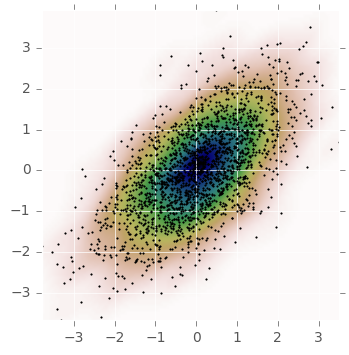

In [98]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

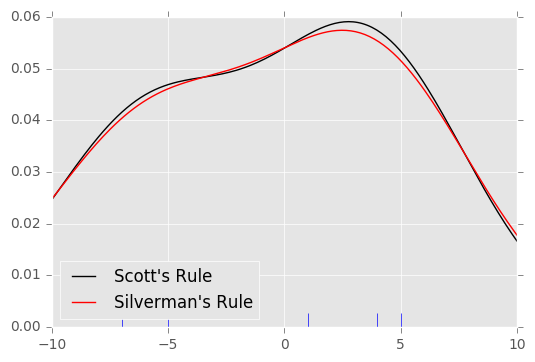

In [99]:
x1 = np.array([-7, -5, 1, 4, 5], dtype=np.float)
kde1 = st.gaussian_kde(x1)
kde2 = st.gaussian_kde(x1, bw_method='silverman')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x1, np.zeros(x1.shape), 'b+', ms=20)  # rug plot
x_eval = np.linspace(-10, 10, num=200)
ax.plot(x_eval, kde1(x_eval), 'k-', label="Scott's Rule")
ax.plot(x_eval, kde2(x_eval), 'r-', label="Silverman's Rule")
plt.legend(loc='best');

# Metropolis 

...Summary...
Acceptance ratio is 0.5058
Mean rho is 0.423321171796
Std for rho is 0.0296829791123
Compare with numpy.cov function: [[ 1.0693  0.4301]
 [ 0.4301  0.9458]]


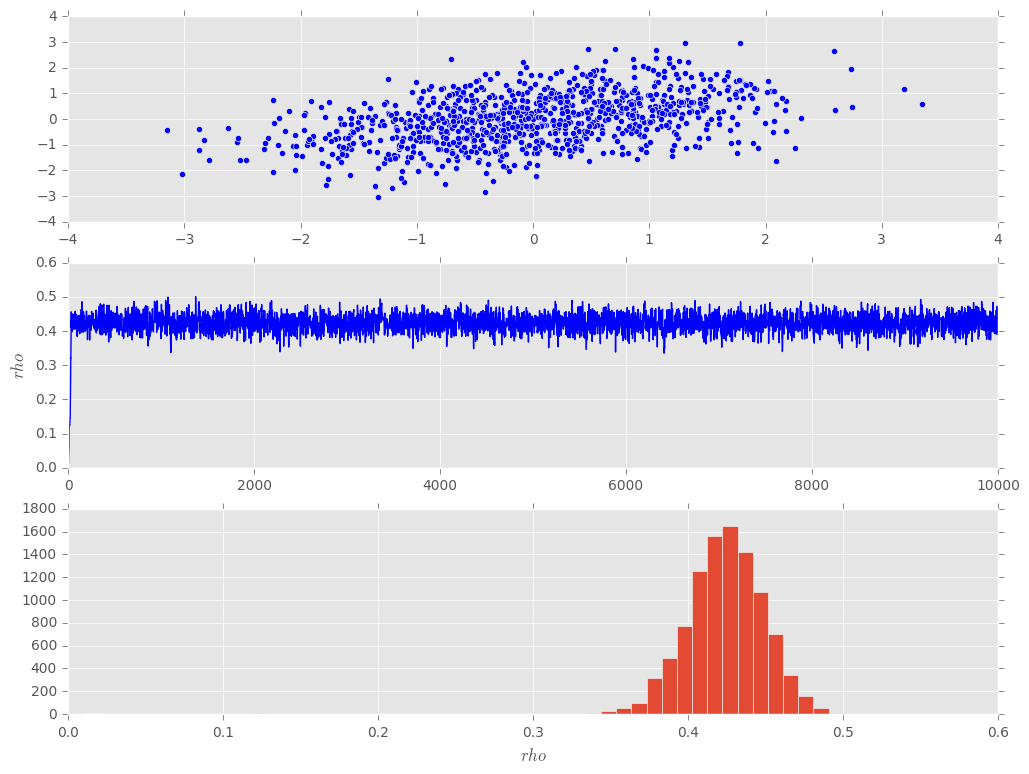

In [101]:
# MH sampler for the correlation model described in the Cognition cheat sheet titled "Metropolis-Hastings sampling."
# Written by Ilker Yildirim, September 2012.

from scipy.stats import uniform, gamma, poisson
import matplotlib.pyplot as plt
import numpy
from numpy import log,exp,pi
from numpy.random import multinomial, multivariate_normal

# fix the random seed for replicability.
numpy.random.seed(12345678)

# Generate data
N=1000
data=multivariate_normal([0,0],[[1, 0.4],[0.4, 1]],N)
x=data[:,0]
y=data[:,1]


# make one big subplots and put everything in it.
f, (ax1,ax2,ax3)=plt.subplots(3,1, figsize=(12,9))
# Plot the data
ax1.scatter(x,y,s=20,c='b',marker='o')

# Gibbs sampler
E=10000
BURN_IN=0

# Initialize the chain. d
rho=0 # as if there's no correlation at all.

# Store the samples
chain_rho=numpy.array([0.]*(E-BURN_IN))

accepted_number=0.
for e in range(E):
	#print "At iteration "+str(e)
	# Draw a value from the proposal distribution, Uniform(rho-0.07,rho+0.07); Equation 7
	rho_candidate=uniform.rvs(rho-0.07,2*0.07)
	
	# Compute the acceptance probability, Equation 8 and Equation 6. 
	# We will do both equations in log domain here to avoid underflow.
	accept=-3./2*log(1.-rho_candidate**2) - N*log((1.-rho_candidate**2)**(1./2)) - sum(1./(2.*(1.-rho_candidate**2))*(x**2-2.*rho_candidate*x*y+y**2))
	accept=accept-(-3./2*log(1.-rho**2) - N*log((1.-rho**2)**(1./2)) - sum(1./(2.*(1.-rho**2))*(x**2-2.*rho*x*y+y**2)))
	accept=min([0,accept])
	accept=exp(accept)

	# Accept rho_candidate with probability accept.
	if uniform.rvs(0,1)<accept:
		rho=rho_candidate
		accepted_number=accepted_number+1
	else:
		rho=rho
	
	# store
	if e>=BURN_IN:
		chain_rho[e-BURN_IN]=rho

print "...Summary..."
print "Acceptance ratio is "+str(accepted_number/(E))
print "Mean rho is "+str(chain_rho.mean())
print "Std for rho is "+str(chain_rho.std())
print "Compare with numpy.cov function: "+str(numpy.cov(data.T))

# plot things
ax2.plot(chain_rho,'b')
ax2.set_ylabel('$rho$')
ax3.hist(chain_rho,50)
ax3.set_xlabel('$rho$')

# Gibbs

In [102]:
%%time

a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

import scipy.stats as stats


prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin,2), np.float)

"""Gibbs sampling. when the full conditionals are available 
and belong to the family of standard distributions (Gamma, Gaussian, etc.),
we will draw the new samples directly."""
for i in range(niters):  
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]

    if i >= burnin:
        thetas[i-burnin] = theta

CPU times: user 20.3 s, sys: 195 ms, total: 20.5 s
Wall time: 20.6 s


In [103]:
thetas[0], thetas[1]

(array([ 0.8814,  0.449 ]), array([ 0.7765,  0.2198]))

In [104]:
thetas.shape

(9500, 2)

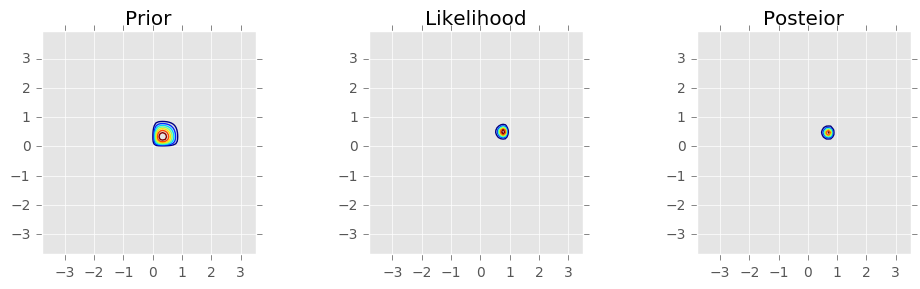

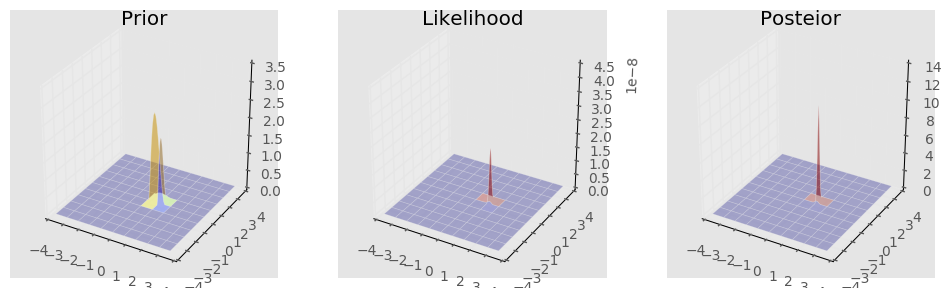

In [105]:
"""We already have Gibbs samples. Using the esitmation of the samples,
find the posterio distribution in 2d"""

kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')

27


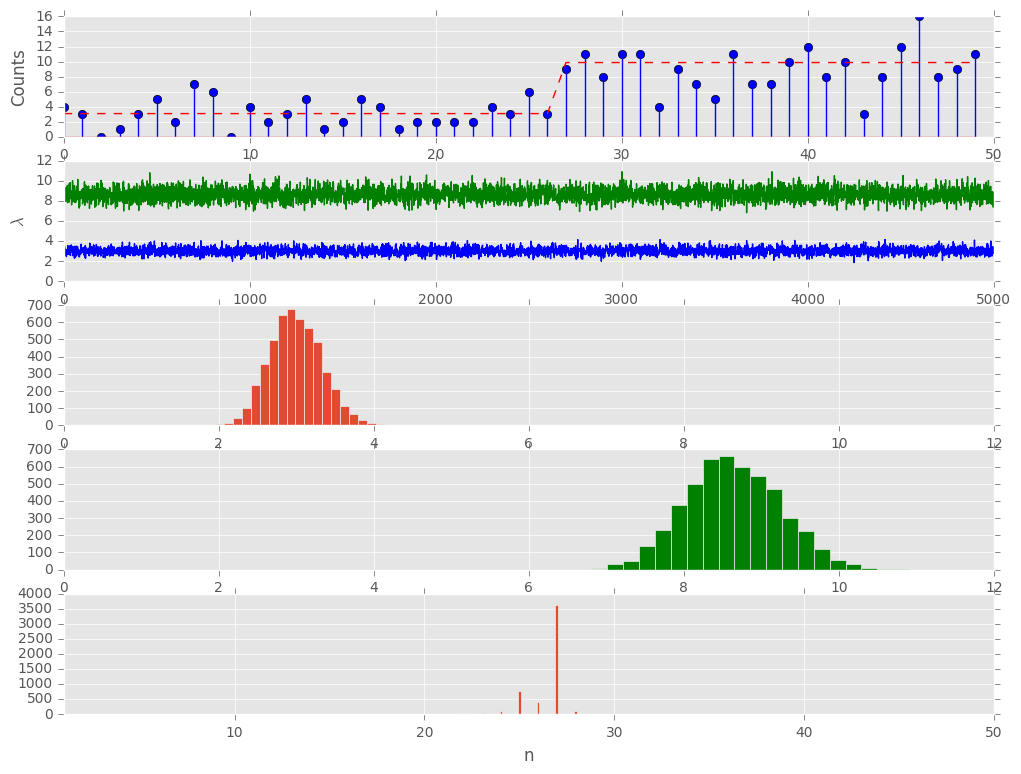

In [106]:
# Gibbs sampler for the change-point model described in a Cognition cheat sheet titled "Gibbs sampling."
# This is a Python implementation of the procedure at http://www.cmpe.boun.edu.tr/courses/cmpe58n/fall2009/
# Written by Ilker Yildirim, September 2012.

from scipy.stats import uniform, gamma, poisson
import matplotlib.pyplot as plt
import numpy
from numpy import log,exp
from numpy.random import multinomial

# fix the random seed for replicability.
numpy.random.seed(123456789)

# Generate data

# Hyperparameters
N=50
a=2
b=1

# Change-point: where the intensity parameter changes.
n=int(round(uniform.rvs()*N))
print str(n)

# Intensity values
lambda1=gamma.rvs(a,scale=1./b) # We use 1/b instead of b because of the way Gamma distribution is parametrized in the package random.
lambda2=gamma.rvs(a,scale=1./b)

lambdas=[lambda1]*n
lambdas[n:N-1]=[lambda2]*(N-n)

# Observations, x_1 ... x_N
x=poisson.rvs(lambdas)

# make one big subplots and put everything in it.
f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1,figsize=(12, 9))


# Plot the data
ax1.stem(range(N),x,linefmt='b-', markerfmt='bo')
ax1.plot(range(N),lambdas,'r--')
ax1.set_ylabel('Counts')

# Gibbs sampler
E=5200
BURN_IN=200

# Initialize the chain
n=int(round(uniform.rvs()*N))
lambda1=gamma.rvs(a,scale=1./b)
lambda2=gamma.rvs(a,scale=1./b)

# Store the samples
chain_n=numpy.array([0.]*(E-BURN_IN))
chain_lambda1=numpy.array([0.]*(E-BURN_IN))
chain_lambda2=numpy.array([0.]*(E-BURN_IN))

for e in range(E):
	#print "At iteration "+str(e)
	# sample lambda1 and lambda2 from their posterior conditionals, Equation 8 and Equation 9, respectively.
	lambda1=gamma.rvs(a+sum(x[0:n]), scale=1./(n+b))
	lambda2=gamma.rvs(a+sum(x[n:N]), scale=1./(N-n+b))
	
	# sample n, Equation 10
	mult_n=numpy.array([0]*N)
	for i in range(N):
		mult_n[i]=sum(x[0:i])*log(lambda1)-i*lambda1+sum(x[i:N])*log(lambda2)-(N-i)*lambda2
	mult_n=exp(mult_n-max(mult_n))
	n=numpy.where(multinomial(1,mult_n/sum(mult_n),size=1)==1)[1][0]
	
	# store
	if e>=BURN_IN:
		chain_n[e-BURN_IN]=n
		chain_lambda1[e-BURN_IN]=lambda1
		chain_lambda2[e-BURN_IN]=lambda2
		

ax2.plot(chain_lambda1,'b',chain_lambda2,'g')
ax2.set_ylabel('$\lambda$')
ax3.hist(chain_lambda1,20)
ax3.set_xlabel('$\lambda_1$')
ax3.set_xlim([0,12])
ax4.hist(chain_lambda2,20,color='g')
ax4.set_xlim([0,12])
ax4.set_xlabel('$\lambda_2$')
ax5.hist(chain_n,50)
ax5.set_xlabel('n')
ax5.set_xlim([1,50])
plt.show()


# Slice sampler

Slice Sampling requires that the distribution to be sampled be evaluable. One way to relax this requirement is to substitute an evaluable distribution which is proportional to the true unevaluable distribution.



In [107]:
%%time

dist = stats.norm(5, 2)
w = 0.5
x = dist.rvs()

niters = 1000
xs = []
while len(xs) < niters:
    y = np.random.uniform(0, dist.pdf(x))
    lb = x
    rb = x
    while y < dist.pdf(lb):
        lb -= w
    while y < dist.pdf(rb):
        rb += w
    x = np.random.uniform(lb, rb)
    if y > dist.pdf(x):
        if np.abs(x-lb) < np.abs(x-rb):
            lb = x
        else:
            lb = y
    else:
        xs.append(x)

CPU times: user 1.88 s, sys: 10.4 ms, total: 1.89 s
Wall time: 1.89 s


In [108]:
len(xs)

1000

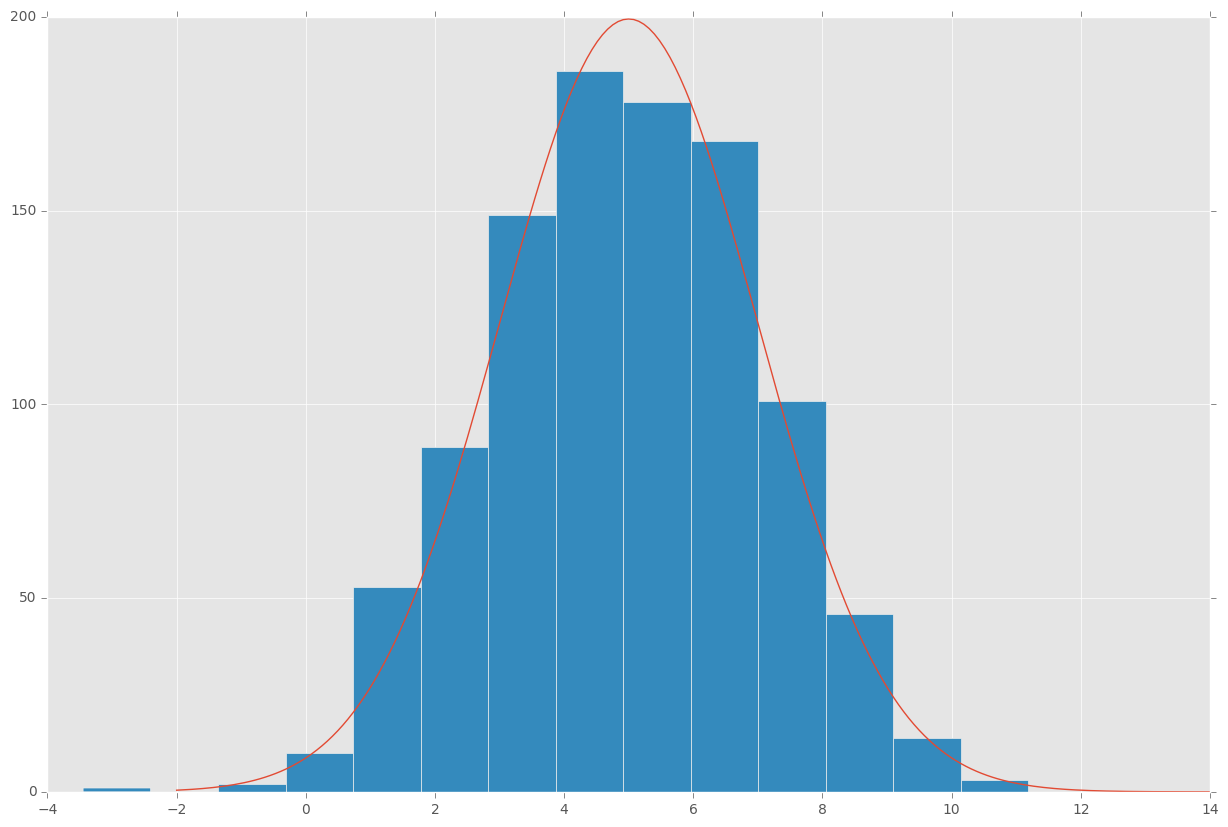

In [109]:
plt.figure(figsize =(15,10))
plt.plot(np.linspace(-2,14,200), len(xs)*stats.norm(5,2).pdf(np.linspace(-2,14,200)))
plt.hist(xs, 14);

In [110]:
from numpy.random import gamma as rgamma # rename so we can use gamma for parameter name

In [111]:
def lambda_update(alpha, beta, y, t):
    return rgamma(size=len(y), shape=y+alpha, scale=1.0/(t+beta))

def beta_update(alpha, gamma, delta, lambd, y):
    return rgamma(size=1, shape=len(y) * alpha + gamma, scale=1.0/(delta + lambd.sum()))

def gibbs(niter, y, t, alpha, gamma, delta):
    lambdas_ = np.zeros((niter, len(y)), np.float)
    betas_ = np.zeros(niter, np.float)

    lambda_ = y/t

    for i in range(niter):
        beta_ = beta_update(alpha, gamma, delta, lambda_, y)
        lambda_ = lambda_update(alpha, beta_, y, t)

        betas_[i] = beta_
        lambdas_[i,:] = lambda_

    return betas_, lambdas_

In [112]:
alpha = 1.8
gamma = 0.01
delta = 1.0
beta0 = 1
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22], np.int)
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48], np.float)
niter = 1000

In [113]:
betas, lambdas = gibbs(niter, y, t, alpha, gamma, delta)
print '%.3f' % betas.mean()
print '%.3f' % betas.std(ddof=1)
print lambdas.mean(axis=0)
print lambdas.std(ddof=1, axis=0)

2.417
0.704
[ 0.0707  0.1545  0.1027  0.1239  0.6381  0.6104  0.8218  0.8624  1.3105
  1.8673]
[ 0.0275  0.0917  0.0373  0.0318  0.2902  0.1355  0.5227  0.5758  0.5635
  0.3937]


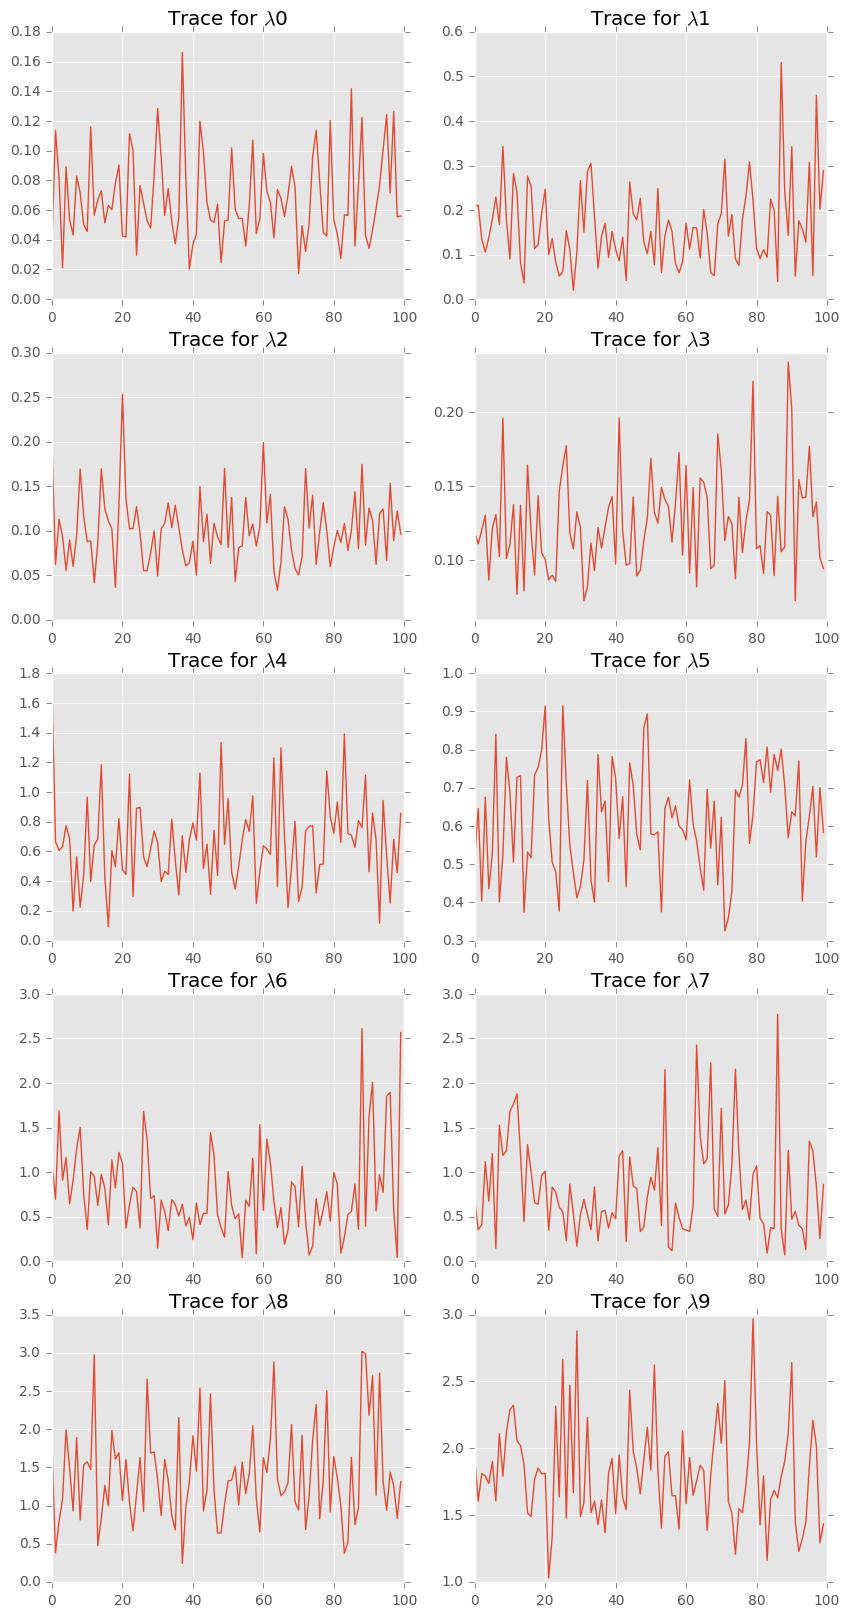

In [114]:
plt.figure(figsize=(10, 20))
for i in range(len(lambdas.T)):
    plt.subplot(5,2,i+1)
    plt.plot(lambdas[::10, i]);
    plt.title('Trace for $\lambda$%d' % i)

Gibbs sampling example

In [20]:
import random,math
 
def gibbs(N=50,thin=10):
    x=0
    y=0
    print "Iter  x  y"
    for i in range(N):
        for j in range(thin):
            x=random.gammavariate(3,1.0/(y*y+4))
            y=random.gauss(1.0/(x+1),1.0/math.sqrt(2*x+2))
        print i,x,y
 
gibbs()

Iter  x  y
0 0.641661750234 1.15861675836
1 0.270315812674 0.287413699571
2 0.136625142942 0.561260573413
3 0.688542685012 0.682213602388
4 1.8837646856 0.692024016151
5 0.125947715352 1.09417611083
6 0.248748584504 0.751271817803
7 0.734936864185 0.366899218962
8 0.746005920081 0.939668447227
9 0.484292029205 0.850304848976
10 1.47804228493 0.349838517642
11 0.227029931659 0.136371858136
12 0.541918753108 0.593548425044
13 0.699208853967 0.810176386602
14 0.568026088054 -0.057153725175
15 0.776258962863 0.987611474053
16 0.614878077527 0.120149663621
17 0.222812574237 1.62328823944
18 0.844630448523 0.671425655736
19 0.279844283705 0.764807447205
20 1.18224110015 0.728102397559
21 0.932043362793 0.663492115879
22 0.081404884771 -0.302462084116
23 0.95844132903 0.0115742421643
24 0.422791005084 1.14924053405
25 1.58587514456 1.16237918759
26 0.119828252241 0.485462287704
27 0.293887396546 0.107169481813
28 1.28258062301 0.978522015005
29 0.874724417017 0.574688710726
30 0.846602729609 